In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!unzip -qn "/content/drive/MyDrive/crop_data_train_val.zip" -d "/content/data/"

In [ ]:
import shutil
shutil.rmtree('/content/data/train/anger_crop')
shutil.rmtree('/content/data/train/happy_crop')
shutil.rmtree('/content/data/train/panic_crop')
shutil.rmtree('/content/data/train/sadness_crop')

In [ ]:
!unzip -qn "/content/drive/MyDrive/aug-crop/anger_cropped_face-.zip" -d "/content/data/train"
!unzip -qn "/content/drive/MyDrive/aug-crop/happy_cropped_face-.zip" -d "/content/data/train"
!unzip -qn "/content/drive/MyDrive/aug-crop/panic_cropped_face-.zip" -d "/content/data/train"
!unzip -qn "/content/drive/MyDrive/aug-crop/sadness_cropped_face-.zip" -d "/content/data/train"

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models
import torch.cuda as cuda
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn.functional as F
from sklearn.utils import shuffle

## Import

In [ ]:
train_df = pd.DataFrame(columns=['filename', 'emotion'])

In [ ]:
# 이미지 파일 경로
train_directories = {
    'anger': '/content/data/train/anger_cropped_face-',
    'happy': '/content/data/train/happy_cropped_face-',
    'panic': '/content/data/train/panic_cropped_face-',
    'sadness': '/content/data/train/sadness_cropped_face-'
}

image_files = {}
for emotion, directory in train_directories.items():
    image_files[emotion] = os.listdir(directory)

dfs = []
for emotion, files in image_files.items():
    data = {'filename': files, 'emotion': [emotion] * len(files)}
    df = pd.DataFrame(data)
    dfs.append(df)

# 모든 데이터프레임을 병합
train_df = pd.concat(dfs, ignore_index=True)

In [ ]:
train_df

,filename,emotion
0,anger010222.jpg,anger
1,anger04156.jpg,anger
2,anger04545.jpg,anger
3,anger040542.jpg,anger
4,anger00157.jpg,anger
...,...,...
19755,sadness04580.jpg,sadness
19756,sadness02958.jpg,sadness
19757,sadness04417.jpg,sadness
19758,sadness02713.jpg,sadness


In [ ]:
# 새로운 img_path 형식을 생성하여 할당
train_df['img_path'] = '/content/data/train/' + train_df['emotion'] + '_cropped_face-/' + train_df['filename']
train_df

,filename,emotion,img_path
0,anger010222.jpg,anger,/content/data/train/anger_cropped_face-/anger0...
1,anger04156.jpg,anger,/content/data/train/anger_cropped_face-/anger0...
2,anger04545.jpg,anger,/content/data/train/anger_cropped_face-/anger0...
3,anger040542.jpg,anger,/content/data/train/anger_cropped_face-/anger0...
4,anger00157.jpg,anger,/content/data/train/anger_cropped_face-/anger0...
...,...,...,...
19755,sadness04580.jpg,sadness,/content/data/train/sadness_cropped_face-/sadn...
19756,sadness02958.jpg,sadness,/content/data/train/sadness_cropped_face-/sadn...
19757,sadness04417.jpg,sadness,/content/data/train/sadness_cropped_face-/sadn...
19758,sadness02713.jpg,sadness,/content/data/train/sadness_cropped_face-/sadn...


In [ ]:
val_df = pd.DataFrame(columns=['filename', 'emotion'])

In [ ]:
# 이미지 파일 경로
val_directories = {
    'anger': '/content/data/val/anger_val_crop',
    'happy': '/content/data/val/happy_val_crop',
    'panic': '/content/data/val/panic_val_crop',
    'sadness': '/content/data/val/sadness_val_crop'
}

image_files = {}
for emotion, directory in val_directories.items():
    image_files[emotion] = os.listdir(directory)

dfs = []
for emotion, files in image_files.items():
    data = {'filename': files, 'emotion': [emotion] * len(files)}
    df = pd.DataFrame(data)
    dfs.append(df)

# 모든 데이터프레임을 병합
val_df = pd.concat(dfs, ignore_index=True)

In [ ]:
# 새로운 img_path 형식을 생성하여 할당
val_df['img_path'] = '/content/data/val/' + val_df['emotion'] + '_val_crop/' + val_df['filename']
val_df

,filename,emotion,img_path
0,anger71.jpg,anger,/content/data/val/anger_val_crop/anger71.jpg
1,anger126.jpg,anger,/content/data/val/anger_val_crop/anger126.jpg
2,anger65.jpg,anger,/content/data/val/anger_val_crop/anger65.jpg
3,anger239.jpg,anger,/content/data/val/anger_val_crop/anger239.jpg
4,anger197.jpg,anger,/content/data/val/anger_val_crop/anger197.jpg
...,...,...,...
1195,sadness94.jpg,sadness,/content/data/val/sadness_val_crop/sadness94.jpg
1196,sadness189.jpg,sadness,/content/data/val/sadness_val_crop/sadness189.jpg
1197,sadness218.jpg,sadness,/content/data/val/sadness_val_crop/sadness218.jpg
1198,sadness53.jpg,sadness,/content/data/val/sadness_val_crop/sadness53.jpg


In [ ]:
le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['emotion'])
val_df['class'] = le.fit_transform(val_df['emotion'])

In [ ]:
len(train_df)

19760

In [ ]:
len(val_df)

1200

In [ ]:
# train_df와 val_df concat
final_df = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# EfficientNetB0 모델 불러오기
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_ftrs, 4)  # 분류할 클래스의 수에 맞게 출력 레이어 수정

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 174MB/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
# EmotionNet 모델 로드
emotionnet = models.googlenet(pretrained=True)

# 출력 계층 수정
num_ftrs = emotionnet.fc.in_features
emotionnet.fc = nn.Linear(num_ftrs, 4)  # 4개 감정 클래스

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 31.3MB/s]


In [ ]:
# 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성 및 데이터로더 설정
dataset = CustomDataset(final_df, transform=transform)

# 손실 함수 및 최적화 기준 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

# 학습 설정
num_epochs = 10  # 학습할 epoch 수 정의

In [ ]:
# 데이터셋 분할: 학습 데이터셋과 검증 데이터셋으로 나누기
train_size = int(len(train_df))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 데이터로더 생성: 학습용과 검증용 데이터로더 각각 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 장치 설정
device = torch.device("cuda" if cuda.is_available() else "cpu")

# 학습 및 검증 함수 정의
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc='Training', dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss / len(train_loader.dataset), running_corrects.double() / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    return running_loss / len(val_loader.dataset), running_corrects.double() / len(val_loader.dataset)



In [ ]:
# 모델을 device로 보내기
efficientnet = efficientnet.to(device)
efficientnet = torch.nn.DataParallel(efficientnet)

emotionnet = emotionnet.to(device)
emotionnet = torch.nn.DataParallel(emotionnet)

In [ ]:
# efficientnet 학습 및 검증 진행
for epoch in range(num_epochs):
    # 학습 단계
    train_loss, train_acc = train(efficientnet, train_loader, optimizer, criterion, device)

    # 검증 단계
    val_loss, val_acc = validate(efficientnet, val_loader, criterion, device)

    # 결과 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Validation: 100%|██████████| 75/75 [00:18<00:00,  4.10it/s]


Epoch 1/10, Train Loss: 0.4939, Train Acc: 0.8144, Val Loss: 0.3272, Val Acc: 0.8783


Validation: 100%|██████████| 75/75 [00:18<00:00,  3.97it/s]


Epoch 2/10, Train Loss: 0.2983, Train Acc: 0.8922, Val Loss: 0.3167, Val Acc: 0.8925


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch 3/10, Train Loss: 0.2114, Train Acc: 0.9231, Val Loss: 0.2226, Val Acc: 0.9275


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.04it/s]


Epoch 4/10, Train Loss: 0.1599, Train Acc: 0.9437, Val Loss: 0.3227, Val Acc: 0.8950


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Epoch 5/10, Train Loss: 0.1241, Train Acc: 0.9575, Val Loss: 0.2570, Val Acc: 0.9133


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.06it/s]


Epoch 6/10, Train Loss: 0.1039, Train Acc: 0.9645, Val Loss: 0.2384, Val Acc: 0.9225


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Epoch 7/10, Train Loss: 0.0835, Train Acc: 0.9711, Val Loss: 0.1869, Val Acc: 0.9408


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.02it/s]


Epoch 8/10, Train Loss: 0.0772, Train Acc: 0.9729, Val Loss: 0.1548, Val Acc: 0.9517


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Epoch 9/10, Train Loss: 0.0659, Train Acc: 0.9774, Val Loss: 0.1933, Val Acc: 0.9350


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.00it/s]

Epoch 10/10, Train Loss: 0.0644, Train Acc: 0.9787, Val Loss: 0.2131, Val Acc: 0.9317


In [ ]:
# 데이터셋 생성 및 데이터로더 설정
dataset = CustomDataset(final_df, transform=transform)

# 손실 함수 및 최적화 기준 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(emotionnet.parameters(), lr=0.001)

# emotionnet 학습 및 검증 진행
for epoch in range(num_epochs):
    # 학습 단계
    train_loss, train_acc = train(emotionnet, train_loader, optimizer, criterion, device)

    # 검증 단계
    val_loss, val_acc = validate(emotionnet, val_loader, criterion, device)

    # 결과 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Validation: 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


Epoch 1/10, Train Loss: 0.5657, Train Acc: 0.7847, Val Loss: 0.4182, Val Acc: 0.8450


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.11it/s]


Epoch 2/10, Train Loss: 0.3990, Train Acc: 0.8558, Val Loss: 0.3515, Val Acc: 0.8733


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.17it/s]


Epoch 3/10, Train Loss: 0.3234, Train Acc: 0.8837, Val Loss: 0.3195, Val Acc: 0.8892


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.15it/s]


Epoch 4/10, Train Loss: 0.2561, Train Acc: 0.9074, Val Loss: 0.2315, Val Acc: 0.9208


Validation: 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


Epoch 5/10, Train Loss: 0.2107, Train Acc: 0.9244, Val Loss: 0.2228, Val Acc: 0.9292


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.16it/s]


Epoch 6/10, Train Loss: 0.1620, Train Acc: 0.9435, Val Loss: 0.2297, Val Acc: 0.9150


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.15it/s]


Epoch 7/10, Train Loss: 0.1372, Train Acc: 0.9526, Val Loss: 0.2023, Val Acc: 0.9275


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.13it/s]


Epoch 8/10, Train Loss: 0.1095, Train Acc: 0.9604, Val Loss: 0.2125, Val Acc: 0.9242


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.11it/s]


Epoch 9/10, Train Loss: 0.0933, Train Acc: 0.9665, Val Loss: 0.1557, Val Acc: 0.9458


Validation: 100%|██████████| 75/75 [00:18<00:00,  4.17it/s]

Epoch 10/10, Train Loss: 0.0882, Train Acc: 0.9693, Val Loss: 0.2151, Val Acc: 0.9317


In [ ]:
!unzip -qn "/content/drive/MyDrive/test_crop.zip" -d "/content/data/"

In [ ]:
test_df = pd.DataFrame(columns=['filename', 'emotion'])
test_directories = {
    'anger': '/content/data/test_crop/anger_crop/',
    'happy': '/content/data/test_crop/happy_crop/',
    'panic': '/content/data/test_crop/panic_crop/',
    'sadness': '/content/data/test_crop/sadness_crop/'
}

In [ ]:
image_files = {}
for emotion, directory in test_directories.items():
    image_files[emotion] = os.listdir(directory)

dfs = []
for emotion, files in image_files.items():
    data = {'filename': files, 'emotion': [emotion] * len(files)}
    df = pd.DataFrame(data)
    dfs.append(df)

test_df = pd.concat(dfs, ignore_index=True)
test_df['img_path'] = '/content/data/test_crop/' + test_df['emotion'] + '_crop/' + test_df['filename']

test_df['class'] = le.transform(test_df['emotion'])  # 감정 라벨을 정수로 변환

In [ ]:
# 테스트 데이터셋 생성 및 데이터로더 설정
test_dataset = CustomDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# 테스트 데이터셋에 대한 모델 성능 평가 함수 정의
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    return test_loss, test_acc, all_preds, all_labels

#EfficientNet 모델 성능 평가


In [ ]:
# 테스트 데이터셋에 대한 모델 성능 평가
test_loss, test_acc, all_preds, all_labels = test(efficientnet, test_loader, criterion, device)

# 테스트 결과 출력
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Testing: 100%|██████████| 71/71 [00:17<00:00,  4.10it/s]

Test Loss: 0.8423, Test Acc: 0.8283


Confusion Matrix:
[[213   1  45  20]
 [ 12 267  12   7]
 [ 25   1 245   4]
 [ 37   3  28 216]]
Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.76      0.75       279
       happy       0.98      0.90      0.94       298
       panic       0.74      0.89      0.81       275
     sadness       0.87      0.76      0.81       284

    accuracy                           0.83      1136
   macro avg       0.84      0.83      0.83      1136
weighted avg       0.84      0.83      0.83      1136

Weighted Precision: 0.8381
Weighted Recall: 0.8283
Weighted F1 Score: 0.8301


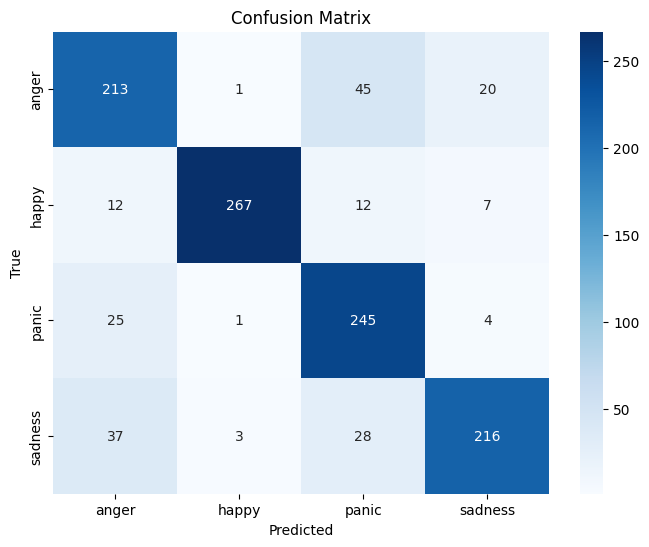

In [ ]:
# 혼동 행렬 및 분류 보고서 출력
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=le.classes_)

# 추가 메트릭 계산
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#EmotionNet 모델 성능 평가

In [ ]:
# 테스트 데이터셋에 대한 모델 성능 평가
test_loss, test_acc, all_preds, all_labels = test(emotionnet, test_loader, criterion, device)

# 테스트 결과 출력
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Testing: 100%|██████████| 71/71 [00:16<00:00,  4.20it/s]

Test Loss: 0.5952, Test Acc: 0.8380


Confusion Matrix:
[[186   5  33  55]
 [  8 276   9   5]
 [ 20   4 240  11]
 [ 15   3  16 250]]
Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.67      0.73       279
       happy       0.96      0.93      0.94       298
       panic       0.81      0.87      0.84       275
     sadness       0.78      0.88      0.83       284

    accuracy                           0.84      1136
   macro avg       0.84      0.84      0.83      1136
weighted avg       0.84      0.84      0.84      1136

Weighted Precision: 0.8405
Weighted Recall: 0.8380
Weighted F1 Score: 0.8364


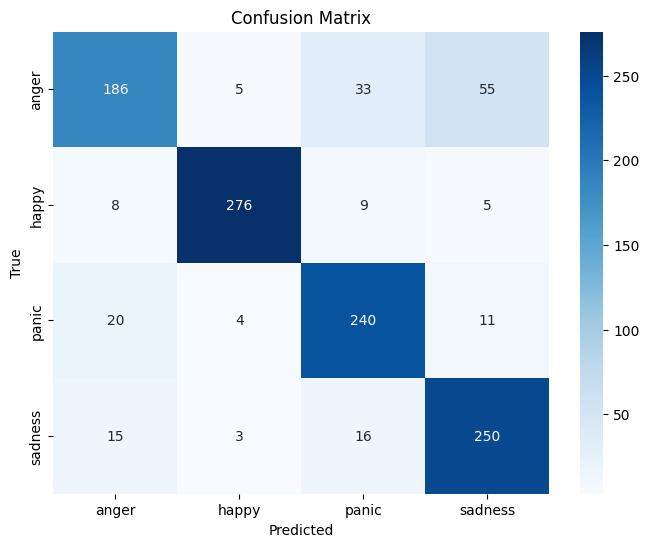

In [ ]:
# 혼동 행렬 및 분류 보고서 출력
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=le.classes_)

# 추가 메트릭 계산
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#앙상블 모델 성능 평가

In [ ]:
pytorch_models = [efficientnet, emotionnet]

# PyTorch 모델 앙상블 예측 함수 정의
def pytorch_ensemble_predict(models, dataloader, device):
    all_probs = []
    all_labels = []
    for inputs, labels in tqdm(dataloader, desc='PyTorch Ensemble Prediction', dynamic_ncols=True):
        inputs = inputs.to(device)
        outputs = []
        with torch.no_grad():
            for model in models:
                model.eval()
                output = model(inputs)
                outputs.append(F.softmax(output, dim=1))
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        all_probs.extend(avg_output.cpu().numpy())
        all_labels.extend(labels.numpy())
    return np.array(all_probs), np.array(all_labels)

# PyTorch 모델로 예측 수행
pytorch_probs, true_labels = pytorch_ensemble_predict(pytorch_models, test_loader, device)

PyTorch Ensemble Prediction: 100%|██████████| 71/71 [00:17<00:00,  3.98it/s]

[[9.7520882e-01 6.1792234e-09 2.5284653e-06 2.4788722e-02]
 [9.2412591e-01 6.3267209e-05 7.4441113e-02 1.3697352e-03]
 [9.6103990e-01 9.5335091e-04 3.7930701e-02 7.6067787e-05]
 ...
 [2.5900939e-05 5.2379221e-07 3.1647424e-04 9.9965703e-01]
 [8.7685947e-07 5.7360476e-06 3.3284549e-02 9.6670884e-01]
 [1.7061526e-03 2.1278585e-01 1.6214810e-03 7.8388643e-01]] [0 0 0 ... 3 3 3]


Confusion Matrix:
[[215   3  36  25]
 [ 11 271  11   5]
 [ 18   4 247   6]
 [ 22   2  24 236]]
Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.77      0.79       279
       happy       0.97      0.91      0.94       298
       panic       0.78      0.90      0.83       275
     sadness       0.87      0.83      0.85       284

    accuracy                           0.85      1136
   macro avg       0.86      0.85      0.85      1136
weighted avg       0.86      0.85      0.85      1136

Precision: 0.857342729758029
Recall: 0.8529929577464789
F1 Score: 0.8536538626475119


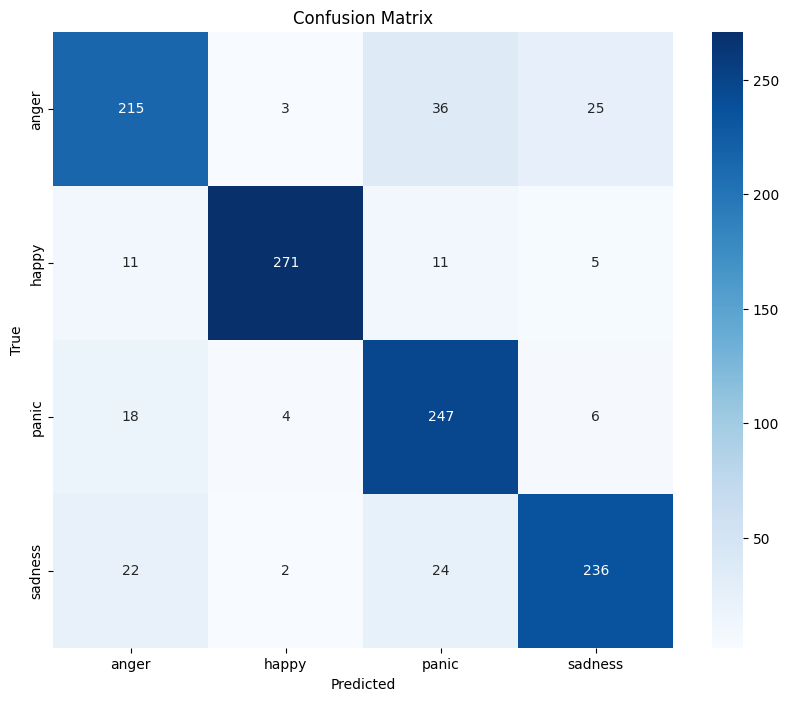

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# 모델 앙상블의 다중 클래스 예측값 생성
ensemble_preds = np.argmax(pytorch_probs, axis=-1)

# 혼동 행렬 계산
cm = confusion_matrix(true_labels, ensemble_preds)


# 분류 보고서 출력
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(true_labels, ensemble_preds, target_names=le.classes_))
print('Precision:', precision_score(true_labels, ensemble_preds, average='weighted'))
print('Recall:', recall_score(true_labels, ensemble_preds, average='weighted'))
print('F1 Score:', f1_score(true_labels, ensemble_preds, average='weighted'))

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def predict_image(model, image_path, transform, device):
    # 이미지 불러오기
    image = Image.open(image_path).convert('RGB')

    # 전처리 및 배치 차원 추가
    image = transform(image).unsqueeze(0).to(device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # 클래스 번호를 예측된 라벨로 변환
    predicted_label = le.inverse_transform(predicted.cpu().numpy())[0]

    # 이미지 출력을 위해 CPU로 이동
    image = image.cpu()

    # 이미지 출력
    plt.imshow(image.squeeze().permute(1, 2, 0))
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

# 이미지 경로
image_path = '/content/happy.png'

# 이미지 예측
predicted_label = predict_image(efficientnet, image_path, transform, device)

FileNotFoundError: [Errno 2] No such file or directory: '/content/happy.png'